In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA      = Path('data')
RAW       = DATA/'raw'
INTERIM   = DATA/'interim'
PROCESSED = DATA/'processed'

In [4]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
market     = pd.read_csv(RAW/'Market.csv', low_memory=False)
macro      = pd.read_csv(RAW/'MarketData_Macro.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [8]:
print(challenge.shape)
challenge.head()

(484758, 6)


,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,a1e0d80784,20180423,1856,13323,Buy,NaN
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN
2,a8e94f6344,20180423,1780,9157,Buy,NaN
3,758bae1e35,20180423,2129,9131,Buy,NaN
4,02ab378ee8,20180423,1758,7151,Buy,NaN


In [9]:
print(customer.shape)
customer.head()

(3471, 5)


,CustomerIdx,Sector,Subsector,Region,Country
0,2975,Banks and Intermediaries,Bank,Americas,BARBADOS
1,1594,Asset Managers & Hedge Funds,NaN,Americas,BERMUDA
2,399,Corporation,Corp - Comm. & Prof. Services,Americas,BERMUDA
3,836,Asset Owners,Insurance,Americas,BERMUDA
4,816,Asset Owners,Insurance,Americas,BERMUDA


In [10]:
print(isin.shape)
isin.head()

(27411, 17)


,IsinIdx,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,0,238,20381231,20051129,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,1.246002e+09,STEP CPN
1,1,238,20331231,20051129,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,4.901086e+09,FIXED
2,2,238,20331231,20051129,GOV,ARS,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,1.501245e+10,FIXED
3,3,236,20170417,20070417,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,B,Government,Sovereign,Domestic,7.340076e+09,FIXED
4,4,234,20221004,20100222,GOV,ARS,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,3.058452e+09,FLOATING


In [11]:
print(market.shape)
market.head()

(9867747, 5)


,IsinIdx,DateKey,Price,Yield,ZSpread
0,1,20160101,104.250,7.835,5.505
1,7,20160101,107.500,7.520,5.541
2,102,20160101,100.746,4.048,2.085
3,331,20160101,112.790,-0.752,-0.215
4,345,20160101,113.383,-0.667,-0.272


In [12]:
print(macro.shape)
macro.head()

(877, 112)


,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
0,20150101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.20,0.116959,0.81620,0.377658,0.861030,1.006264,0.161512,0.163399,1.2101,1.55775,0.128941,0.000081,0.008341,0.133451,0.756287,0.428964,0.086457,35.230452,2.724540,1.303309,-0.063143,3.701588,3.617925,0.077487,0.561227,0.381829,7.17183,0.112078,1.459648,0.709986,10.001685,0.256570,6.130798,19.989643,29.980614,21.985733,3.041150,2.398950,3.625076,2.558248,NaN,NaN,NaN,2.277279,NaN,2.760043,1.775859,0.409878,NaN,1.082563,-0.046046,3.749868,3.418686,NaN,3.549519,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.697389,NaN,1.408397,0.233572,NaN,NaN,NaN,NaN,2.252274,0.95467,NaN,1.814259,8.955845,8.368177,9.552123,8.708471,0.444559,NaN,1.233032,0.180984,1.806932,NaN,2.179804,1.295793,NaN,NaN,NaN,NaN,9.885583,10.069276,9.915120,2.295037,NaN,2.712112,1.774452,7.963276,6.856526,8.331874,7.403867
1,20150102,NaN,9764.73,3139.44,26.2531,6547.80,23857.82,NaN,17832.99,2058.20,17.79,0.116891,0.81140,0.371292,0.851136,0.998851,0.161186,0.163292,1.2008,1.53340,0.128934,0.000080,0.008308,0.131841,0.752757,0.427241,0.085609,33.000000,2.736281,1.302850,-0.063000,3.701588,3.617925,0.077179,0.563380,0.385000,7.10000,0.112078,1.490000,0.790000,10.020000,0.255218,6.125000,20.000000,30.000000,22.000000,3.108394,2.452905,3.692179,2.625847,11.767860,12.807338,12.202677,2.231223,1.445105,2.716551,1.748069,0.367391,NaN,1.040147,-0.058452,3.750081,3.419989,NaN,3.550031,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.640191,0.062120,1.347191,0.211268,1.674890,0.810358,2.109754,1.305976,2.290000,0.97500,2.751960,1.840000,8.950000,8.350000,9.550000,8.700000,0.444559,NaN,1.233032,0.180984,1.794443,1.100220,2.168744,1.280511,2.447394,1.132505,2.951900,1.948474,9.946260,10.151881,9.976101,2.236910,0.893242,2.647499,1.746344,7.940000,6.840000,8.310000,7.390000
2,20150105,3350.519,9473.16,3023.14,29.6236,6417.16,23721.32,17408.71,17501.65,2020.58,19.92,0.116782,0.80905,0.366757,0.850268,0.993764,0.160822,0.163265,1.1939,1.52555,0.128926,0.000079,0.008366,0.131277,0.749260,0.429304,0.085426,32.000000,2.742523,1.303171,-0.063000,3.749732,3.691439,0.075252,0.563380,0.383570,7.10000,0.112140,1.450000,0.875000,9.993400,0.254194,6.125000,20.000000,30.000000,22.000000,3.007227,2.423082,3.591836,2.566016,11.809585,12.736379,12.154331,2.180266,1.420899,2.668708,1.713829,0.350011,-0.263049,0.981356,-0.069792,3.700010,3.405070,NaN,3.500016,3.700010,3.405070,NaN,3.500016,3.450010,3.230070,NaN,3.250016,0.658914,0.063256,1.351414,0.220293,1.613752,0.799833,2.043961,1.251222,2.190000,0.94000,2.652800,1.750000,8.950000,8.350000,9.550000,8.700000,0.436972,0.112315,1.225011,0.178599,1.747772,1.06362

In [13]:
print(submission.shape)
submission.head()

(484758, 2)


,PredictionIdx,CustomerInterest
0,a1e0d80784,0.374540
1,c2cc6cc2a8,0.950714
2,a8e94f6344,0.731994
3,758bae1e35,0.598658
4,02ab378ee8,0.156019


In [14]:
print(trade.shape)
trade.head()

(6762021, 8)


,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
0,20161207,2789,8478,Sell,653168.0,0.0,Unknown,1.0
1,20170329,2574,14562,Buy,1656487.0,0.0,Unknown,1.0
2,20170418,2574,4747,Buy,939673.0,0.0,Unknown,1.0
3,20170310,2574,9885,Sell,708082.0,0.0,Unknown,1.0
4,20161116,2574,8885,Buy,1147709.0,0.0,Unknown,1.0


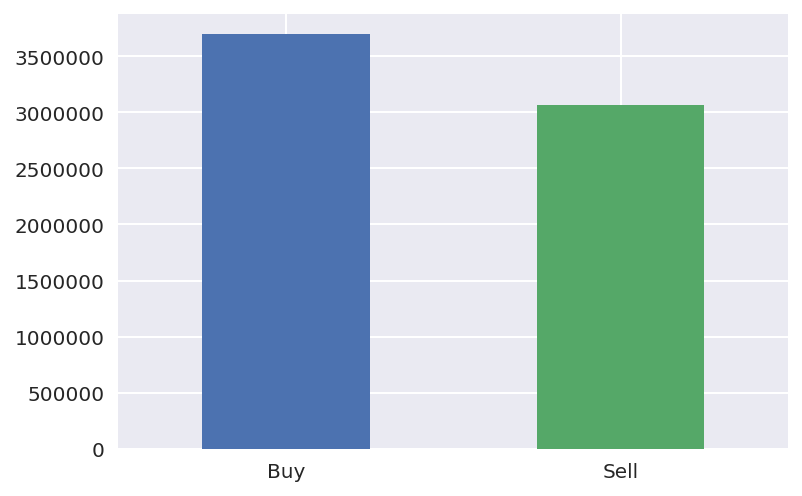

In [18]:
trade.BuySell.value_counts().plot.bar(rot=0)

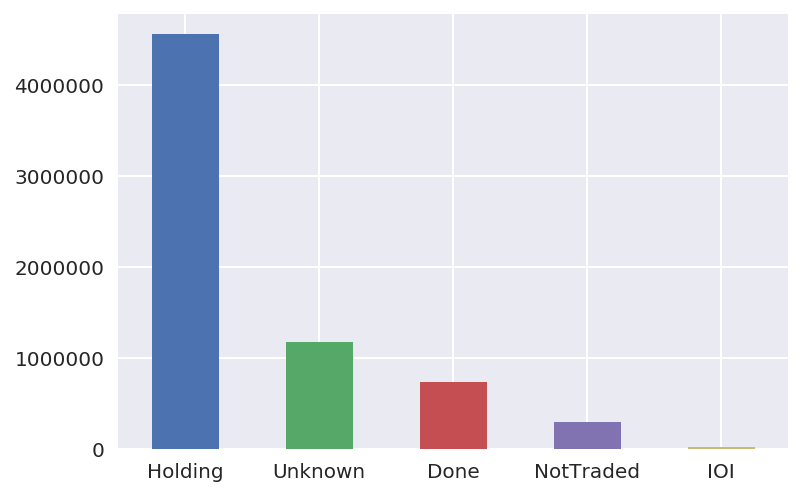

In [19]:
trade.TradeStatus.value_counts().plot.bar(rot=0)

In [27]:
trade.TradeDateKey.nunique()

684

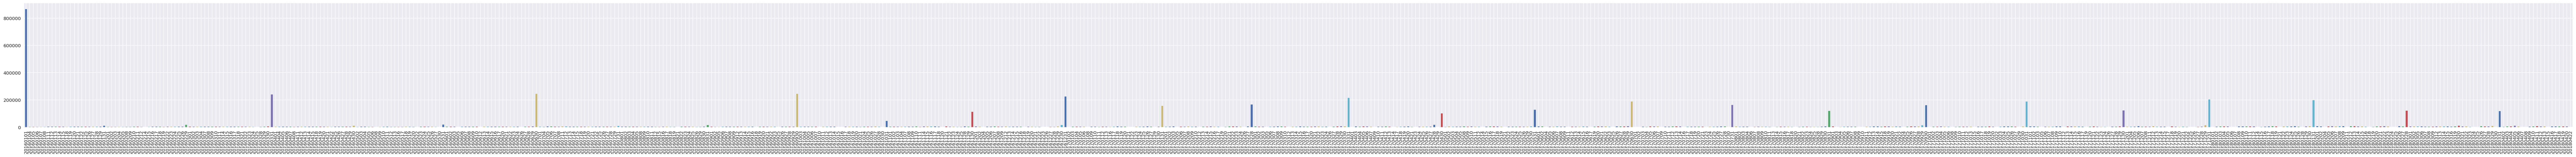

In [28]:
# Activity increases at the end of each month
trade.TradeDateKey.value_counts().sort_index().plot.bar(figsize=(100,5))

In [29]:
# There is historical information for all customers in test
set(challenge.CustomerIdx).difference(trade.CustomerIdx)

set()

In [31]:
# There is historical information for all bonds in test
set(challenge.IsinIdx).difference(trade.IsinIdx)

set()

In [33]:
# There is metadata for all customers in test
set(trade.CustomerIdx).difference(customer.CustomerIdx)

set()

In [34]:
# There is metadata for all bonds in test
set(trade.IsinIdx).difference(isin.IsinIdx)

set()

In [206]:
# There is historical information for all (customer, bonds) in test
set(zip(challenge.CustomerIdx, challenge.IsinIdx)).difference(list(zip(trade.CustomerIdx, trade.IsinIdx)))

set()

## Null

In [46]:
trade.apply(lambda x: sum(x.isnull()), axis=0)

TradeDateKey              0
CustomerIdx               0
IsinIdx                   0
BuySell                   0
NotionalEUR               0
Price               4617933
TradeStatus               0
CustomerInterest          0
dtype: int64

In [38]:
trade.apply(lambda x: sum(x.isnull())/len(x), axis=0)

TradeDateKey        0.000000
CustomerIdx         0.000000
IsinIdx             0.000000
BuySell             0.000000
NotionalEUR         0.000000
Price               0.682922
TradeStatus         0.000000
CustomerInterest    0.000000
dtype: float64

In [47]:
customer.apply(lambda x: sum(x.isnull()), axis=0)

CustomerIdx      0
Sector           0
Subsector      352
Region           0
Country          0
dtype: int64

In [42]:
customer.apply(lambda x: sum(x.isnull())/len(x), axis=0)

CustomerIdx    0.000000
Sector         0.000000
Subsector      0.101412
Region         0.000000
Country        0.000000
dtype: float64

In [45]:
isin.apply(lambda x: sum(x.isnull()), axis=0)

IsinIdx                   0
TickerIdx                 0
ActualMaturityDateKey     0
IssueDateKey              0
Seniority                 0
Currency                  0
ActivityGroup             0
Region                    0
Activity                  0
RiskCaptain               0
Owner                     0
CompositeRating           0
IndustrySector            5
IndustrySubgroup          5
MarketIssue              17
IssuedAmount              0
CouponType                0
dtype: int64

In [43]:
isin.apply(lambda x: sum(x.isnull())/len(x), axis=0)

IsinIdx                  0.000000
TickerIdx                0.000000
ActualMaturityDateKey    0.000000
IssueDateKey             0.000000
Seniority                0.000000
Currency                 0.000000
ActivityGroup            0.000000
Region                   0.000000
Activity                 0.000000
RiskCaptain              0.000000
Owner                    0.000000
CompositeRating          0.000000
IndustrySector           0.000182
IndustrySubgroup         0.000182
MarketIssue              0.000620
IssuedAmount             0.000000
CouponType               0.000000
dtype: float64

In [50]:
macro_nulls = macro.apply(lambda x: sum(x.isnull()), axis=0)

In [53]:
macro_nulls[macro_nulls>0]

SSE               2
DAX               1
EUROSTOXX         1
VSTOXX            2
FTSE100           1
HSI               1
NIKKEI            2
DOWJONES_INDU     1
SP500             1
Swap_BRL10Y       1
Swap_BRL2Y        1
Swap_BRL5Y        1
Swap_CAD2Y        1
Swap_CHF2Y        2
Swap_CNH30Y      29
Swap_CNO30Y      29
Swap_CNY30Y      29
Swap_EUR2Y        1
Swap_GBP10Y       1
Swap_GBP2Y        1
Swap_GBP30Y       1
Swap_GBP5Y        1
Swap_HKD30Y       1
Swap_JPY2Y        2
Swap_NOK2Y        1
Swap_SGD10Y       1
Swap_SGD2Y        1
Swap_SGD30Y       1
Swap_SGD5Y        1
Swap_USD2Y        1
dtype: int64

## Macro prices

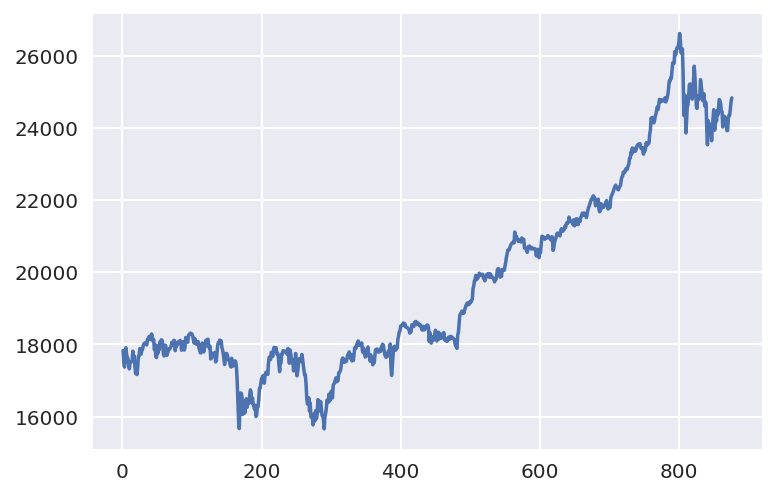

In [56]:
macro['DOWJONES_INDU'].plot()

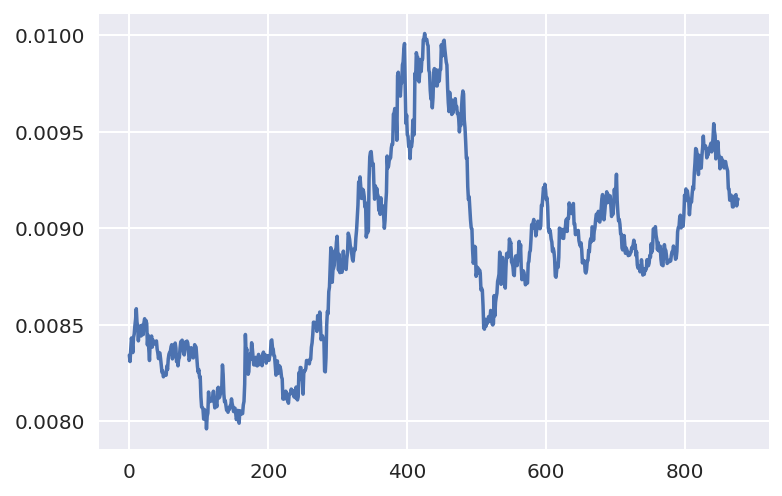

In [57]:
macro['FX_USD.JPY'].plot()

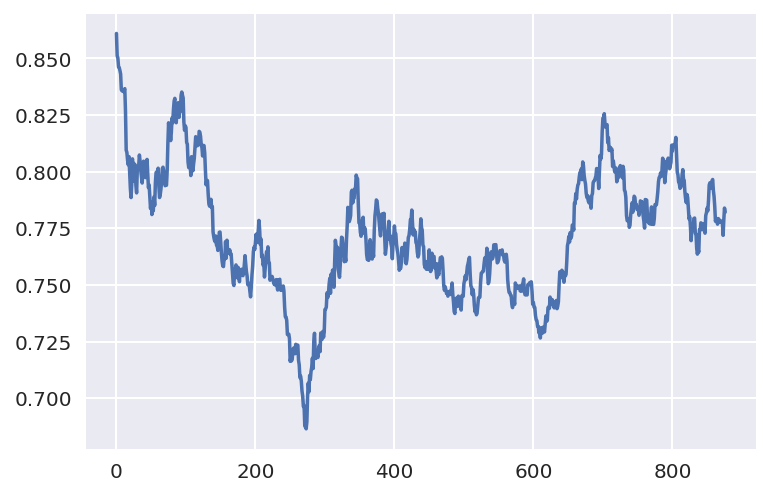

In [58]:
macro['FX_USD.CAD'].plot()

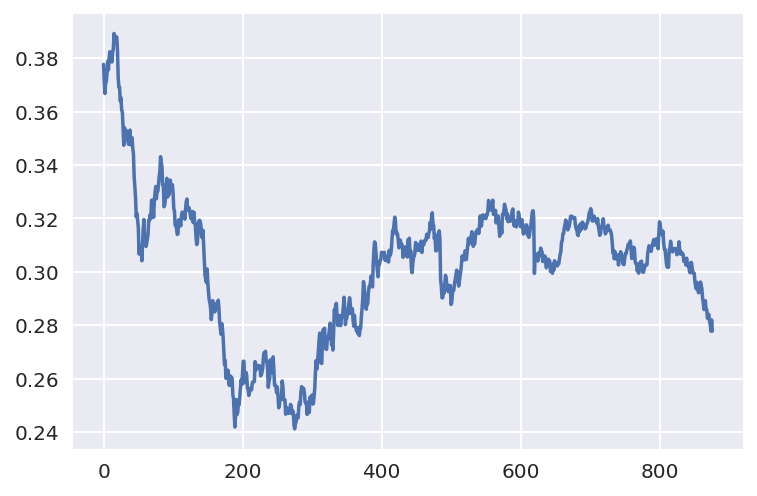

In [59]:
macro['FX_USD.BRL'].plot()

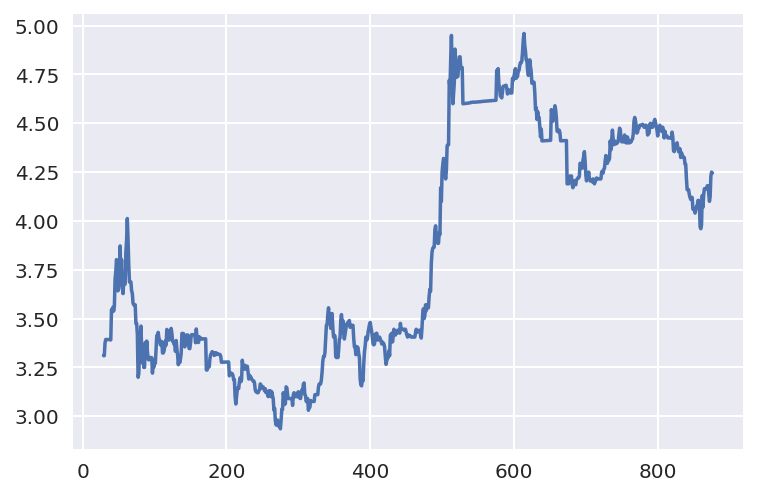

In [60]:
macro['Swap_CNH30Y'].plot()

## #Trades / Customer

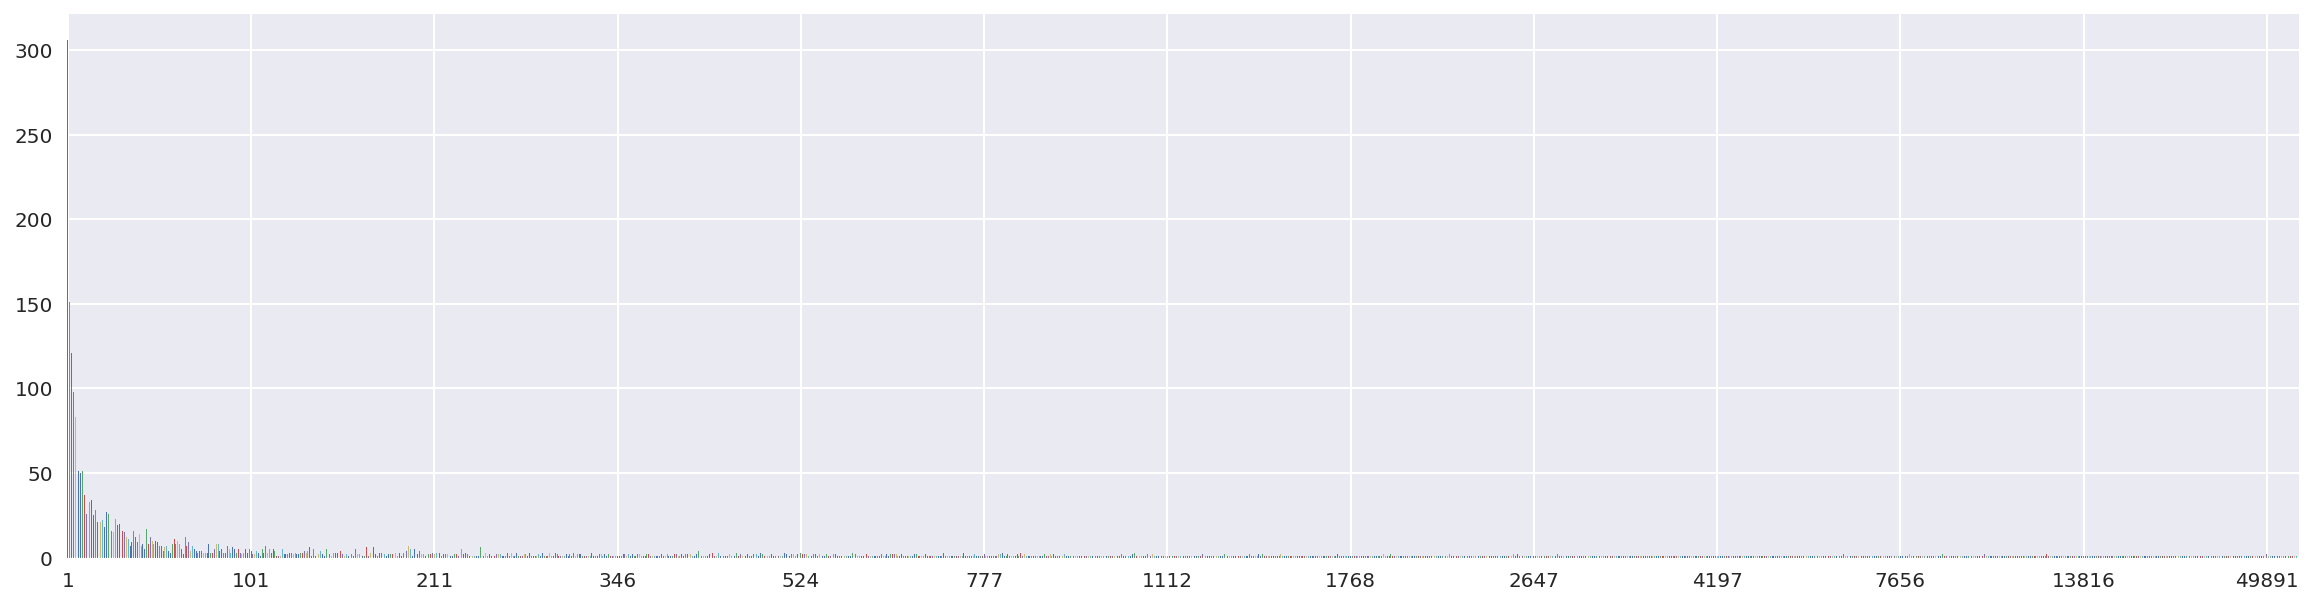

In [93]:
# 8.82% of the customers (306) have 1 trade
# A quarter of the customers have from 1 to 7 trades. 
# Half of the customers have from 1 to 55 trades
# The other half have from 56 to 154,077 trades
n = 100
ax = trade.groupby('CustomerIdx').size().value_counts().sort_index().plot.bar(rot=0, figsize=(20,5))
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
_ = ax.xaxis.set_ticklabels(ticklabels[::n])
# Frequency of trades count

In [94]:
306/3471

0.0881590319792567

In [86]:
# Frequency of trades count
trade.groupby('CustomerIdx').size().value_counts().sort_index().head(10)

1     306
2     151
3     121
4      98
5      83
6      70
7      51
8      50
9      51
10     37
dtype: int64

In [140]:
# Frequency of trades count
trade.groupby('CustomerIdx').size().value_counts().sort_index().tail(10)

72429     1
78081     1
89817     1
90343     1
96485     1
104965    1
117468    1
119014    1
120146    1
154077    1
dtype: int64

In [82]:
trade.groupby('CustomerIdx').size().describe()

count      3439.000000
mean       1966.275371
std        7911.310868
min           1.000000
25%           7.000000
50%          55.000000
75%         574.000000
max      154077.000000
dtype: float64

Text(1500,90,'The maximum amount of trades per customer is 154,077')

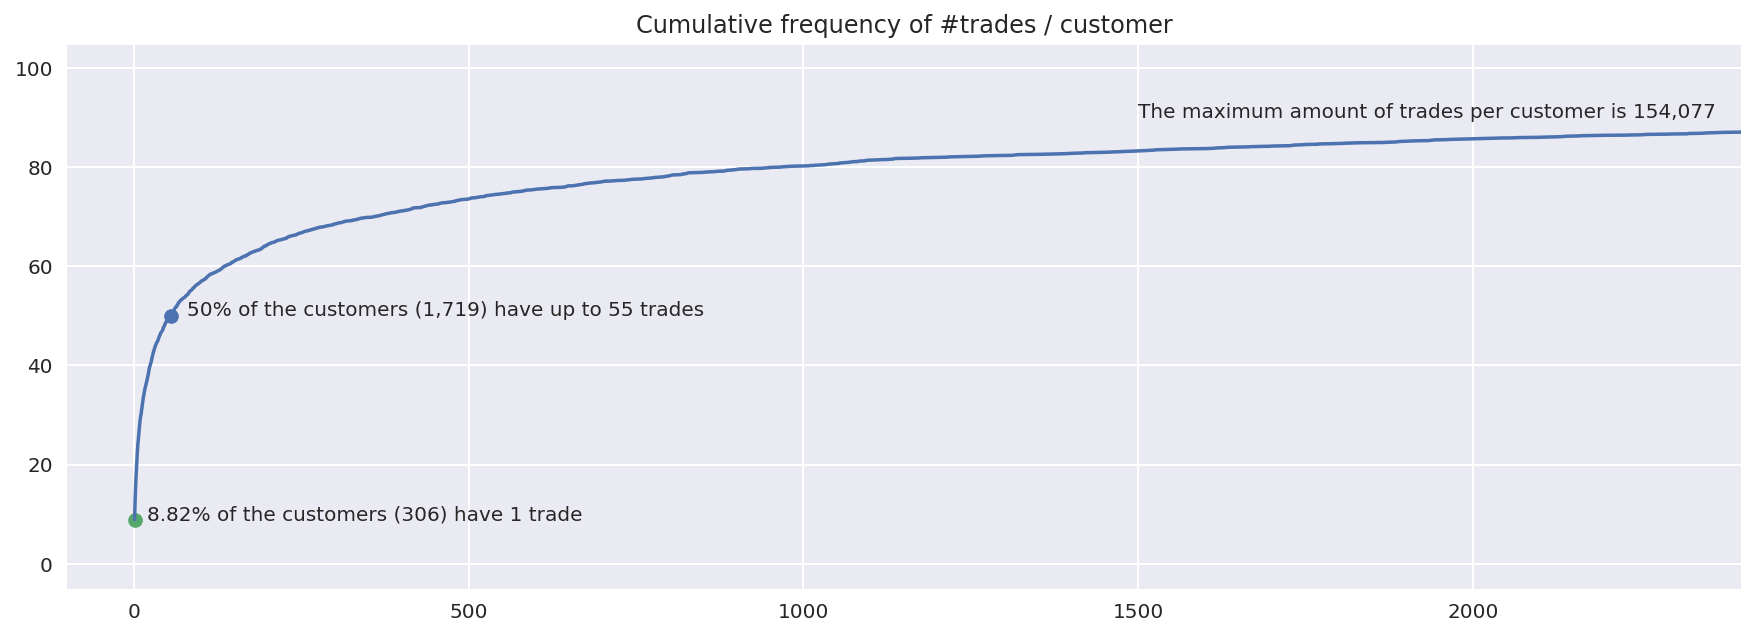

In [177]:
trade_counts = trade.groupby('CustomerIdx').size().value_counts().sort_index()
ax = (trade_counts.cumsum()/trade_counts.sum()*100).plot(figsize=(15,5), 
                            title='Cumulative frequency of #trades / customer')
ax.set_xlim(left=-100, right=2400)
ax.set_ylim(bottom=-5)
ax.scatter(55, 50)
ax.annotate('50% of the customers (1,719) have up to 55 trades', (80, 50))
ax.scatter(1, 100*306/3471)
ax.annotate('8.82% of the customers (306) have 1 trade', (20, 100*306/3471))
ax.annotate('The maximum amount of trades per customer is 154,077', (1500, 90))
# Trades count per customer (cum distribution)

## #Trades / Bond

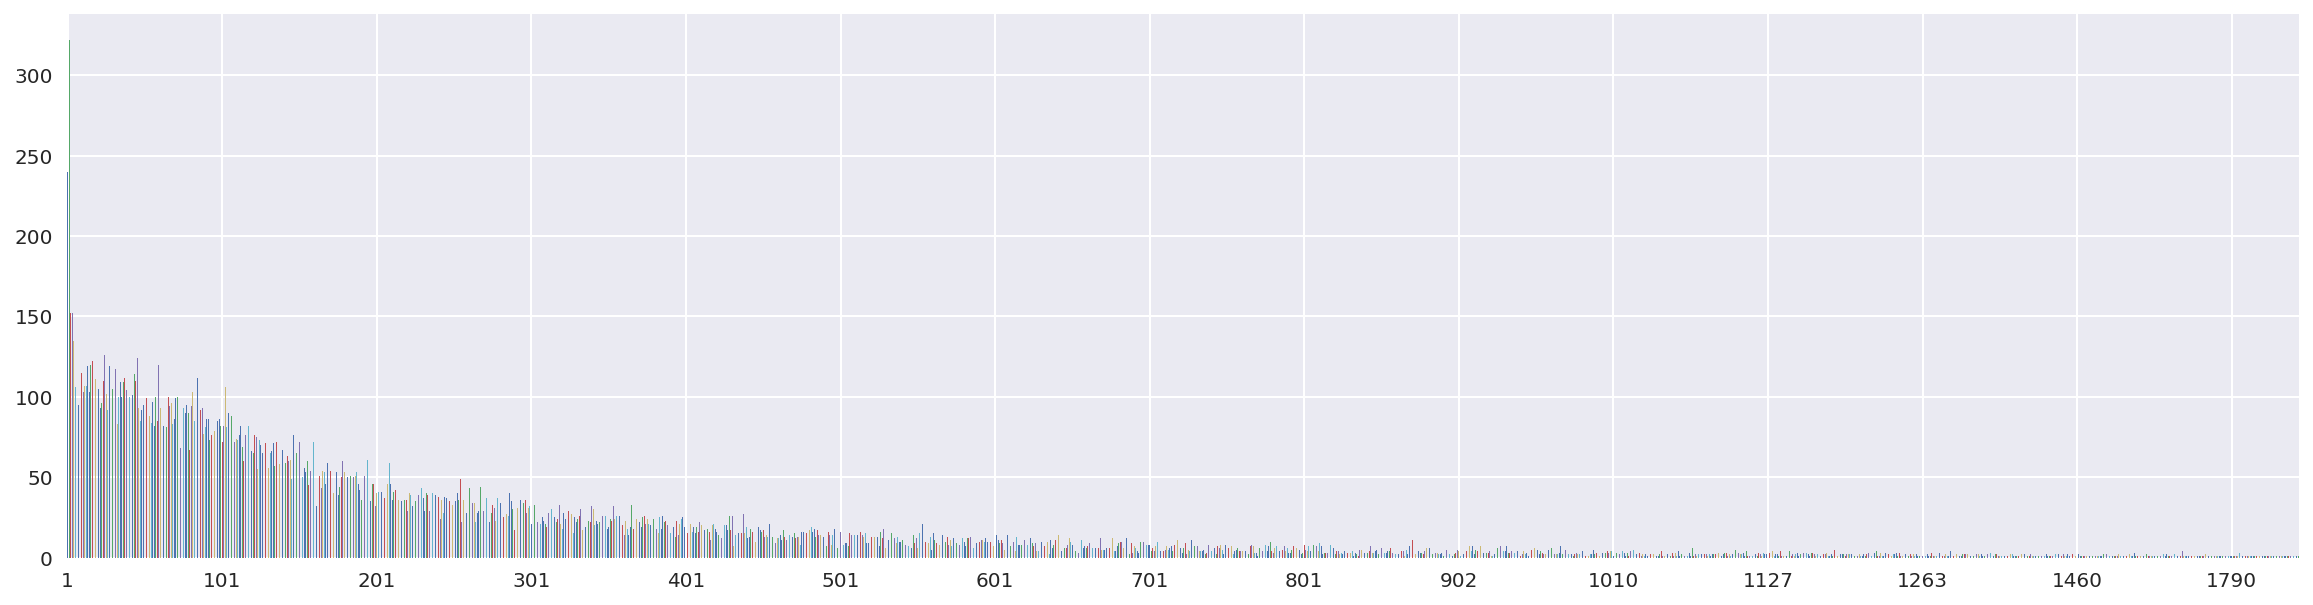

In [141]:
n = 100
ax = trade.groupby('IsinIdx').size().value_counts().sort_index().plot.bar(rot=0, figsize=(20,5))
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
_ = ax.xaxis.set_ticklabels(ticklabels[::n])

In [142]:
# Frequency of trades count
trade.groupby('IsinIdx').size().value_counts().sort_index().head(10)

1     240
2     322
3     152
4     152
5     135
6     106
7     107
8      95
9     112
10    115
dtype: int64

In [143]:
# Frequency of trades count
trade.groupby('IsinIdx').size().value_counts().sort_index().tail(10)

2638    1
2687    1
2707    1
2723    1
2825    1
2883    1
2973    1
2991    1
3168    1
3248    1
dtype: int64

In [144]:
trade.groupby('IsinIdx').size().describe()

count    27305.000000
mean       247.647720
std        279.575663
min          1.000000
25%         63.000000
50%        151.000000
75%        333.000000
max       3248.000000
dtype: float64

In [149]:
100*240/27305

0.8789598974546786

Text(2250,90,'The maximum amount of trades per bond is 3,248')

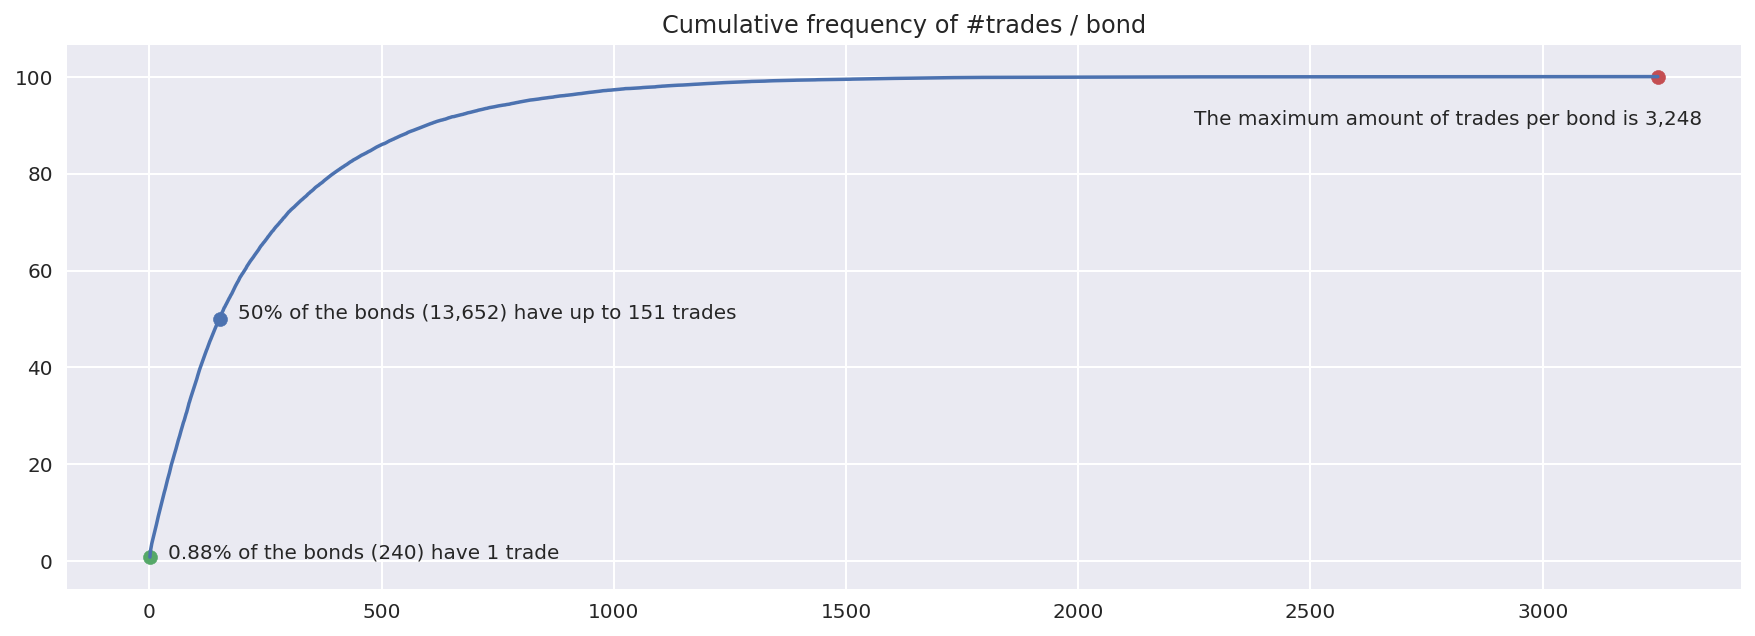

In [164]:
trade_counts = trade.groupby('IsinIdx').size().value_counts().sort_index()
ax = (trade_counts.cumsum()/trade_counts.sum()*100).plot(figsize=(15,5), 
                            title='Cumulative frequency of #trades / bond')
# ax.set_xlim(left=-100, right=2400)
ax.scatter(151, 50)
ax.annotate('50% of the bonds (13,652) have up to 151 trades', (191, 50))
ax.scatter(1, 100*240/27305)
ax.annotate('0.88% of the bonds (240) have 1 trade', (40, 100*204/27305))
ax.scatter(3248, 100)
ax.annotate('The maximum amount of trades per bond is 3,248', (2250, 90))
# Trades count per customer (cum distribution)

## #Trades / (customer,bond)

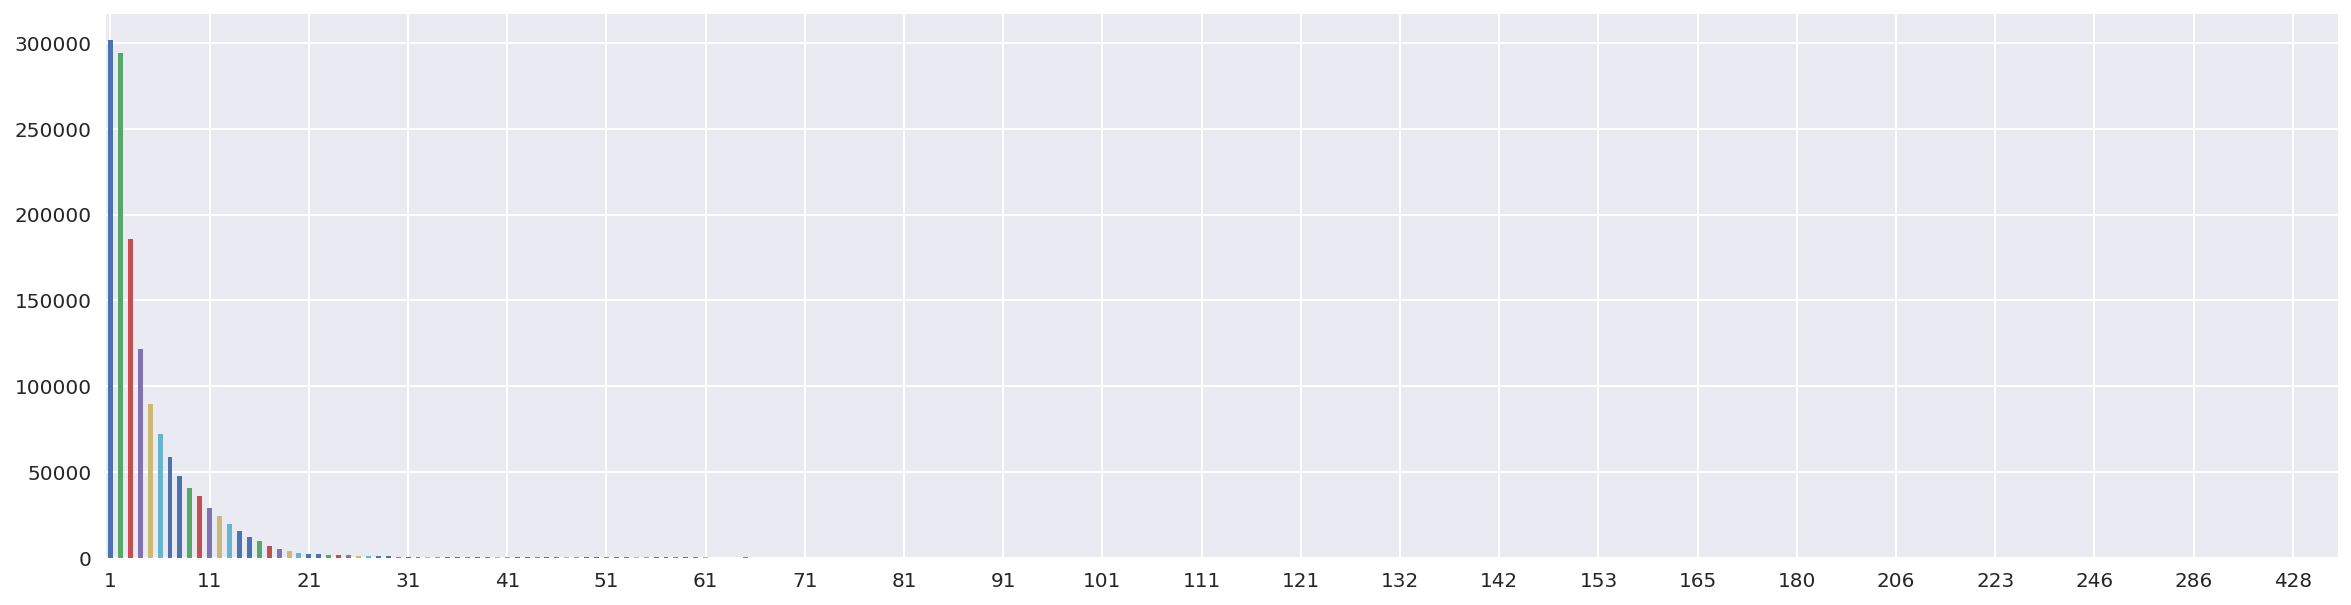

In [166]:
n = 10
ax = trade.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index().plot.bar(rot=0, figsize=(20,5))
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
_ = ax.xaxis.set_ticklabels(ticklabels[::n])

In [167]:
# Frequency of trades count
trade.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index().head(10)

1     301811
2     293997
3     185754
4     121474
5      89333
6      71942
7      58620
8      47438
9      40452
10     35873
dtype: int64

In [168]:
# Frequency of trades count
trade.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index().tail(10)

342    1
374    1
376    1
380    1
406    1
428    1
473    1
479    1
572    1
709    1
dtype: int64

In [169]:
trade.groupby(['CustomerIdx', 'IsinIdx']).size().describe()

count    1.395659e+06
mean     4.845038e+00
std      5.865535e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      7.090000e+02
dtype: float64

In [176]:
301811/1.395659e+06 * 100

21.62498146037105

Text(57,90,'The maximum amount of trades per (customer,bond) pair is 709')

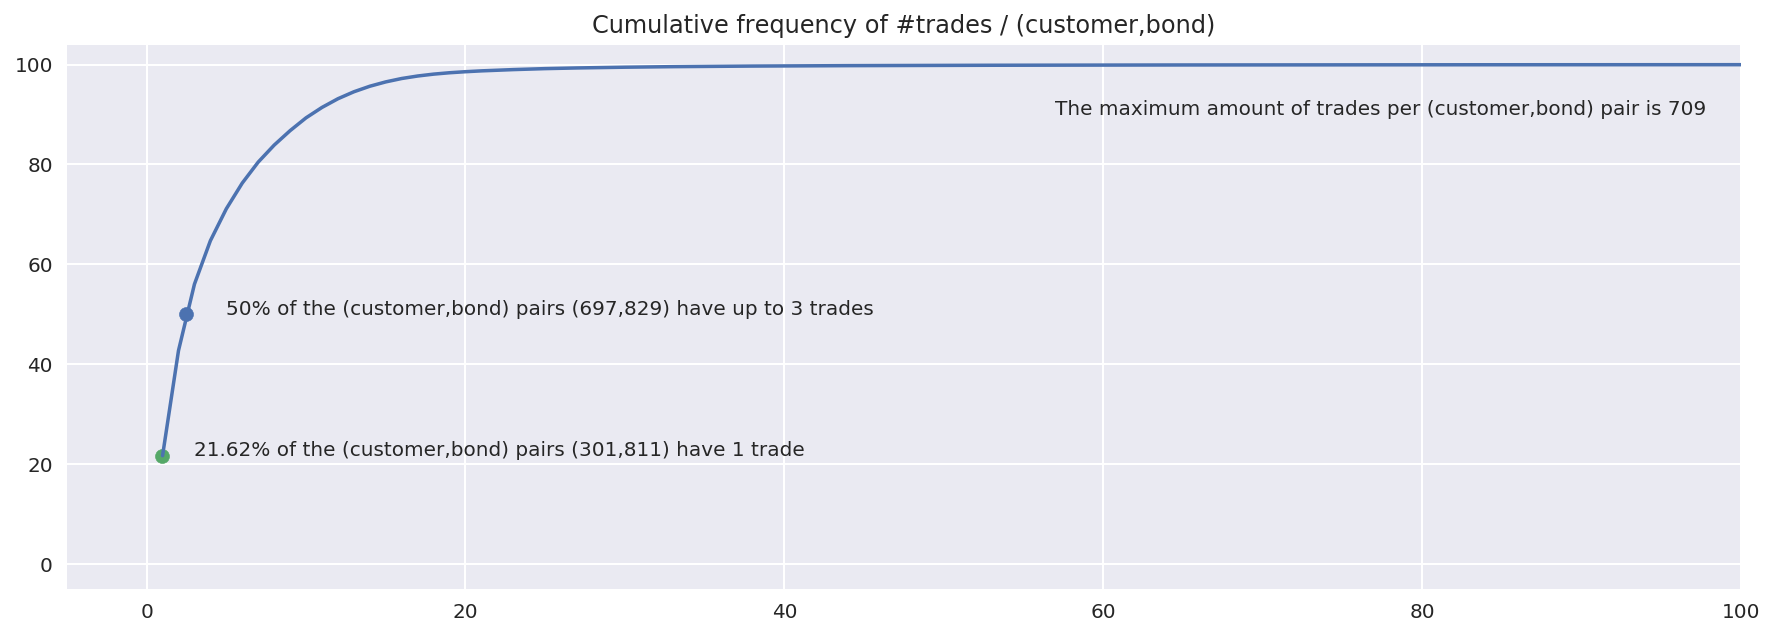

In [186]:
trade_counts = trade.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index()
ax = (trade_counts.cumsum()/trade_counts.sum()*100).plot(figsize=(15,5), 
                            title='Cumulative frequency of #trades / (customer,bond)')
ax.set_xlim(left=-5, right=100)
ax.set_ylim(bottom=-5)
ax.scatter(2.5, 50)
ax.annotate('50% of the (customer,bond) pairs (697,829) have up to 3 trades', (5, 50))
ax.scatter(0.95, 100*301811/1.395659e+06)
ax.annotate('21.62% of the (customer,bond) pairs (301,811) have 1 trade', (3, 100*301811/1.395659e+06))
ax.annotate('The maximum amount of trades per (customer,bond) pair is 709', (57, 90))

## Customers history

In [187]:
trade.sample(5)

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
5539393,20160630,2866,19744,Buy,518399.0,NaN,Holding,0.0
1439510,20161114,2779,8016,Buy,4609994.0,133.8,Unknown,1.0
863497,20170316,586,7517,Buy,699823.0,70.0,Unknown,1.0
6420309,20160101,2280,13705,Buy,8023369.0,NaN,Holding,0.0
4278320,20171231,2180,18801,Buy,70320.0,NaN,Holding,0.0


In [190]:
trade[(trade.CustomerIdx == 2866) & (trade.IsinIdx == 19744)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
6672687,20160101,2866,19744,Sell,33253.0,NaN,Holding,0.0
5539392,20160331,2866,19744,Sell,710301.0,NaN,Holding,0.0
5539393,20160630,2866,19744,Buy,518399.0,NaN,Holding,0.0
5539394,20160930,2866,19744,Sell,100831.0,NaN,Holding,0.0
5539395,20161031,2866,19744,Buy,299515.0,NaN,Holding,0.0
5539396,20170331,2866,19744,Buy,216329.0,NaN,Holding,0.0
5539397,20170430,2866,19744,Buy,824973.0,NaN,Holding,0.0
5539398,20170731,2866,19744,Sell,409164.0,NaN,Holding,0.0
5539399,20171031,2866,19744,Sell,385276.0,NaN,Holding,0.0
5539400,20180131,2866,19744,Sell,277701.0,NaN,Holding,0.0


In [191]:
customer_idx = 2779
isin_idx = 8016
trade[(trade.CustomerIdx == customer_idx) & (trade.IsinIdx == isin_idx)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
6637662,20160101,2779,8016,Buy,3015437.0,NaN,Holding,0.0
5399159,20160630,2779,8016,Buy,3015437.0,NaN,Holding,0.0
1439510,20161114,2779,8016,Buy,4609994.0,133.8,Unknown,1.0


### Check random (Customer,Bond) history

In [205]:
customer_idx, isin_idx = trade[['CustomerIdx', 'IsinIdx']].sample(1).values[0]
trade[(trade.CustomerIdx == customer_idx) & (trade.IsinIdx == isin_idx)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
6326486,20160101,2090,24574,Buy,1009247.0,NaN,Holding,0.0
4065360,20160630,2090,24574,Buy,1894822.0,NaN,Holding,0.0
1148248,20160916,2090,24574,Buy,500000.0,101.000,Unknown,1.0
4065361,20160930,2090,24574,Buy,212224.0,NaN,Holding,0.0
4065362,20161130,2090,24574,Sell,88696.0,NaN,Holding,0.0
4065363,20161231,2090,24574,Sell,427635.0,NaN,Holding,0.0
477453,20170210,2090,24574,Buy,1000000.0,103.165,NotTraded,1.0
4065364,20170331,2090,24574,Buy,1199617.0,NaN,Holding,0.0
476284,20170403,2090,24574,Sell,500000.0,101.808,Done,1.0
4065365,20170630,2090,24574,Sell,1752868.0,NaN,Holding,0.0


### Manual labeling

In [207]:
challenge.head()

,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,a1e0d80784,20180423,1856,13323,Buy,NaN
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN
2,a8e94f6344,20180423,1780,9157,Buy,NaN
3,758bae1e35,20180423,2129,9131,Buy,NaN
4,02ab378ee8,20180423,1758,7151,Buy,NaN


In [210]:
customer_idx, isin_idx = challenge[['CustomerIdx', 'IsinIdx']].head(5).values[1]
trade[(trade.CustomerIdx == customer_idx) & (trade.IsinIdx == isin_idx)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
6208441,20160101,1856,9230,Buy,22007730.0,NaN,Holding,0.0
3552198,20170131,1856,9230,Buy,916964.0,NaN,Holding,0.0
1600979,20170213,1856,9230,Buy,1023422.0,0.0,NotTraded,1.0
3552199,20170228,1856,9230,Buy,108895.0,NaN,Holding,0.0
3552200,20170331,1856,9230,Buy,7075906.0,NaN,Holding,0.0
3552201,20170430,1856,9230,Buy,4679.0,NaN,Holding,0.0
3552202,20170930,1856,9230,Buy,8224130.0,NaN,Holding,0.0
65,20171108,1856,9230,Buy,1078749.0,0.0,Unknown,1.0
3552203,20171130,1856,9230,Buy,7435250.0,NaN,Holding,0.0
1725967,20180124,1856,9230,Sell,772609.0,-99999.0,Unknown,1.0


In [211]:
customer_idx, isin_idx = challenge[['CustomerIdx', 'IsinIdx']].head(5).values[2]
trade[(trade.CustomerIdx == customer_idx) & (trade.IsinIdx == isin_idx)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
116,20171207,1780,9157,Sell,4239803.0,0.0,Unknown,1.0
117,20171212,1780,9157,Sell,4242321.0,0.0,Unknown,1.0


In [212]:
customer_idx, isin_idx = challenge[['CustomerIdx', 'IsinIdx']].head(5).values[3]
trade[(trade.CustomerIdx == customer_idx) & (trade.IsinIdx == isin_idx)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
6348637,20160101,2129,9131,Sell,2969479.0,NaN,Holding,0.0
118,20171213,2129,9131,Sell,2294914.0,0.0,Unknown,1.0
4148074,20171231,2129,9131,Sell,2969479.0,NaN,Holding,0.0


In [213]:
customer_idx, isin_idx = challenge[['CustomerIdx', 'IsinIdx']].head(5).values[4]
trade[(trade.CustomerIdx == customer_idx) & (trade.IsinIdx == isin_idx)].sort_values('TradeDateKey')

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
6163244,20160101,1758,7151,Sell,1090592.0,NaN,Holding,0.0
3391693,20161231,1758,7151,Sell,1090592.0,NaN,Holding,0.0
3391694,20170930,1758,7151,Buy,507958.0,NaN,Holding,0.0
3391695,20171031,1758,7151,Sell,507958.0,NaN,Holding,0.0
380,20171113,1758,7151,Sell,514293.0,0.0,Unknown,1.0


### History for each (customer,bond)

In [214]:
# There is historical information for all (customer, bonds) in test
test_idxs = set(zip(challenge.CustomerIdx, challenge.IsinIdx))

In [215]:
df = trade[trade.apply(lambda row: (row.CustomerIdx, row.IsinIdx) in test_idxs, axis=1)]

In [217]:
trade.shape

(6762021, 8)

In [216]:
df.shape

(1596819, 8)

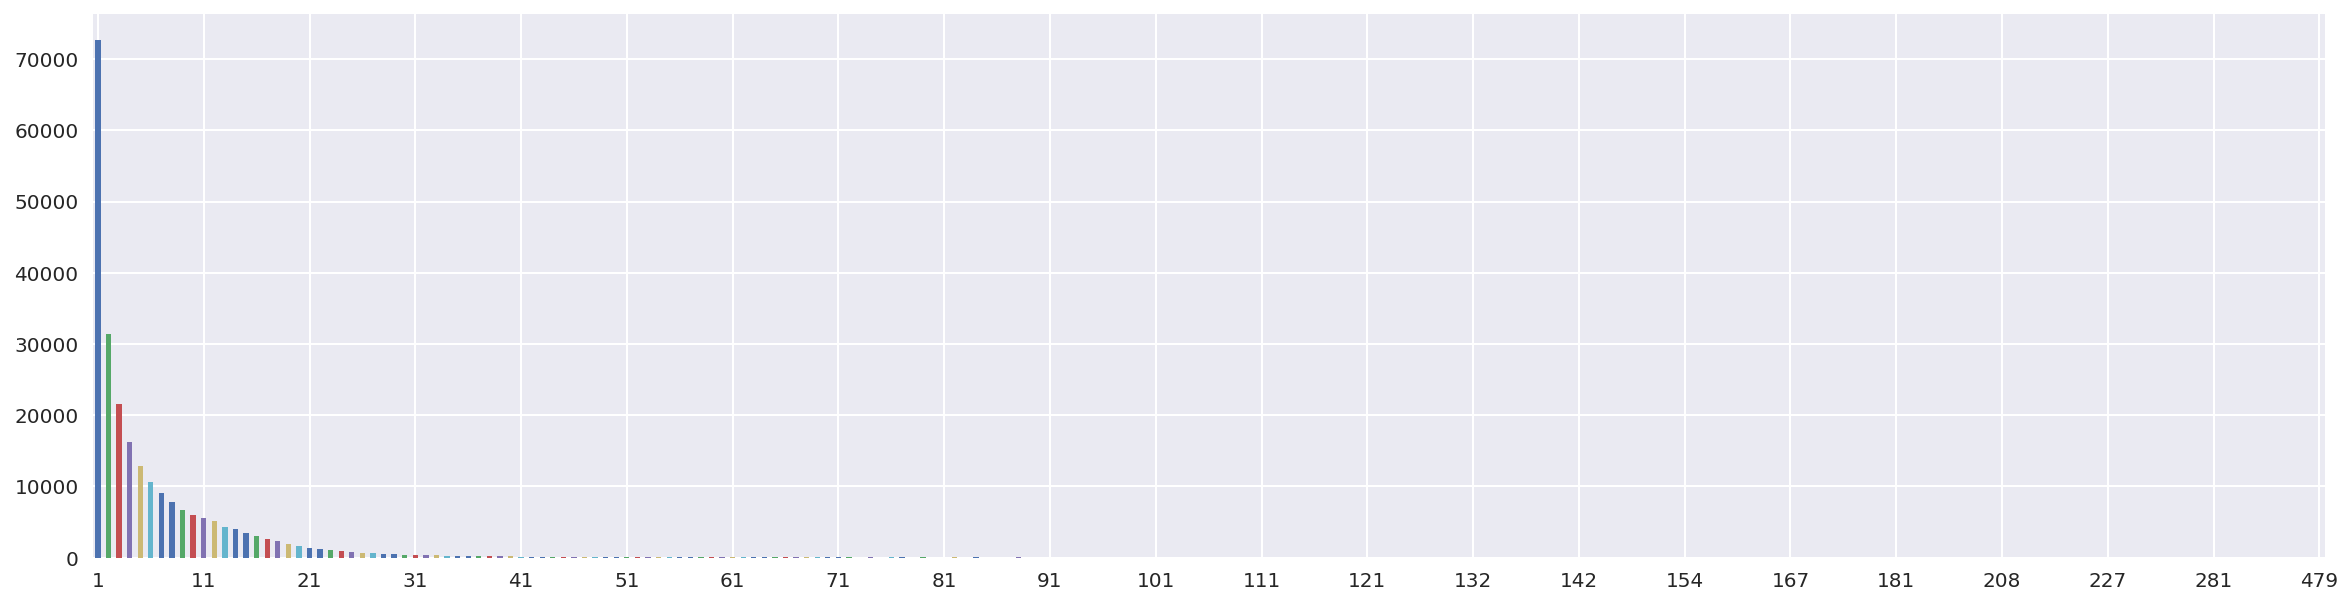

In [220]:
n = 10
ax = df.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index().plot.bar(rot=0, figsize=(20,5))
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
_ = ax.xaxis.set_ticklabels(ticklabels[::n])

In [221]:
# Frequency of trades count
df.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index().head(10)

1     72705
2     31331
3     21506
4     16279
5     12828
6     10638
7      9079
8      7814
9      6725
10     5978
dtype: int64

In [222]:
# Frequency of trades count
df.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index().tail(10)

282    1
286    1
287    1
300    1
320    1
342    1
380    1
406    1
428    1
479    1
dtype: int64

In [228]:
challenge.shape[0] / 2

242379.0

In [218]:
df.groupby(['CustomerIdx', 'IsinIdx']).size().describe()

count    242379.000000
mean          6.588108
std           9.831165
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         479.000000
dtype: float64

Text(57,90,'The maximum amount of trades per (customer,bond) pair is 479')

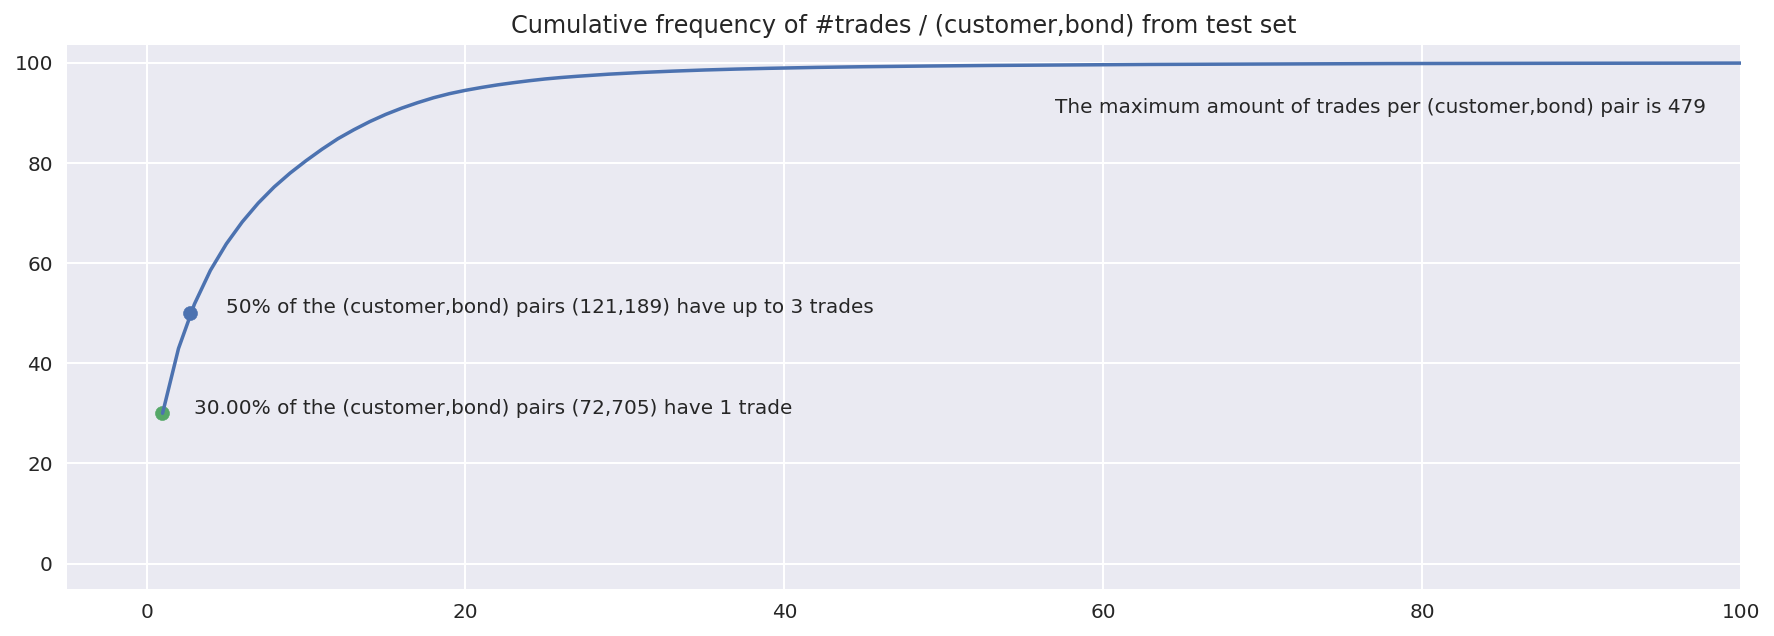

In [233]:
trade_counts = df.groupby(['CustomerIdx', 'IsinIdx']).size().value_counts().sort_index()
ax = (trade_counts.cumsum()/trade_counts.sum()*100).plot(figsize=(15,5), 
                            title='Cumulative frequency of #trades / (customer,bond) from test set')
ax.set_xlim(left=-5, right=100)
ax.set_ylim(bottom=-5)
ax.scatter(2.75, 50)
ax.annotate('50% of the (customer,bond) pairs (121,189) have up to 3 trades', (5, 50))
ax.scatter(0.95, 100*72705/242379)
ax.annotate('30.00% of the (customer,bond) pairs (72,705) have 1 trade', (3, 100*72705/242379))
ax.annotate('The maximum amount of trades per (customer,bond) pair is 479', (57, 90))

In [236]:
print(challenge.shape)
challenge.head()

(484758, 6)


,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,a1e0d80784,20180423,1856,13323,Buy,NaN
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN
2,a8e94f6344,20180423,1780,9157,Buy,NaN
3,758bae1e35,20180423,2129,9131,Buy,NaN
4,02ab378ee8,20180423,1758,7151,Buy,NaN


### Query per date

In [246]:
datekey = 20180419
print(trade[trade.TradeDateKey == datekey].shape)
trade[trade.TradeDateKey == datekey].head()

(5140, 8)


,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
1642,20180419,809,2589,Sell,1300000.0,100.1050,Unknown,1.0
15244,20180419,2412,483,Sell,1000472.0,103.6610,Done,1.0
15689,20180419,176,6401,Sell,807852.0,-99999.0000,Unknown,1.0
16232,20180419,3314,16976,Buy,807852.0,99.2000,Unknown,1.0
16580,20180419,2280,14807,Buy,5453003.0,103.3482,NotTraded,1.0


In [251]:
# There are 849,110 historical data points and 417,599 of them belong to test set (242,379 customer,bond pairs)
trade[trade.TradeDateKey > 20180000].shape, df[df.TradeDateKey > 20180000].shape

((849110, 8), (417599, 8))

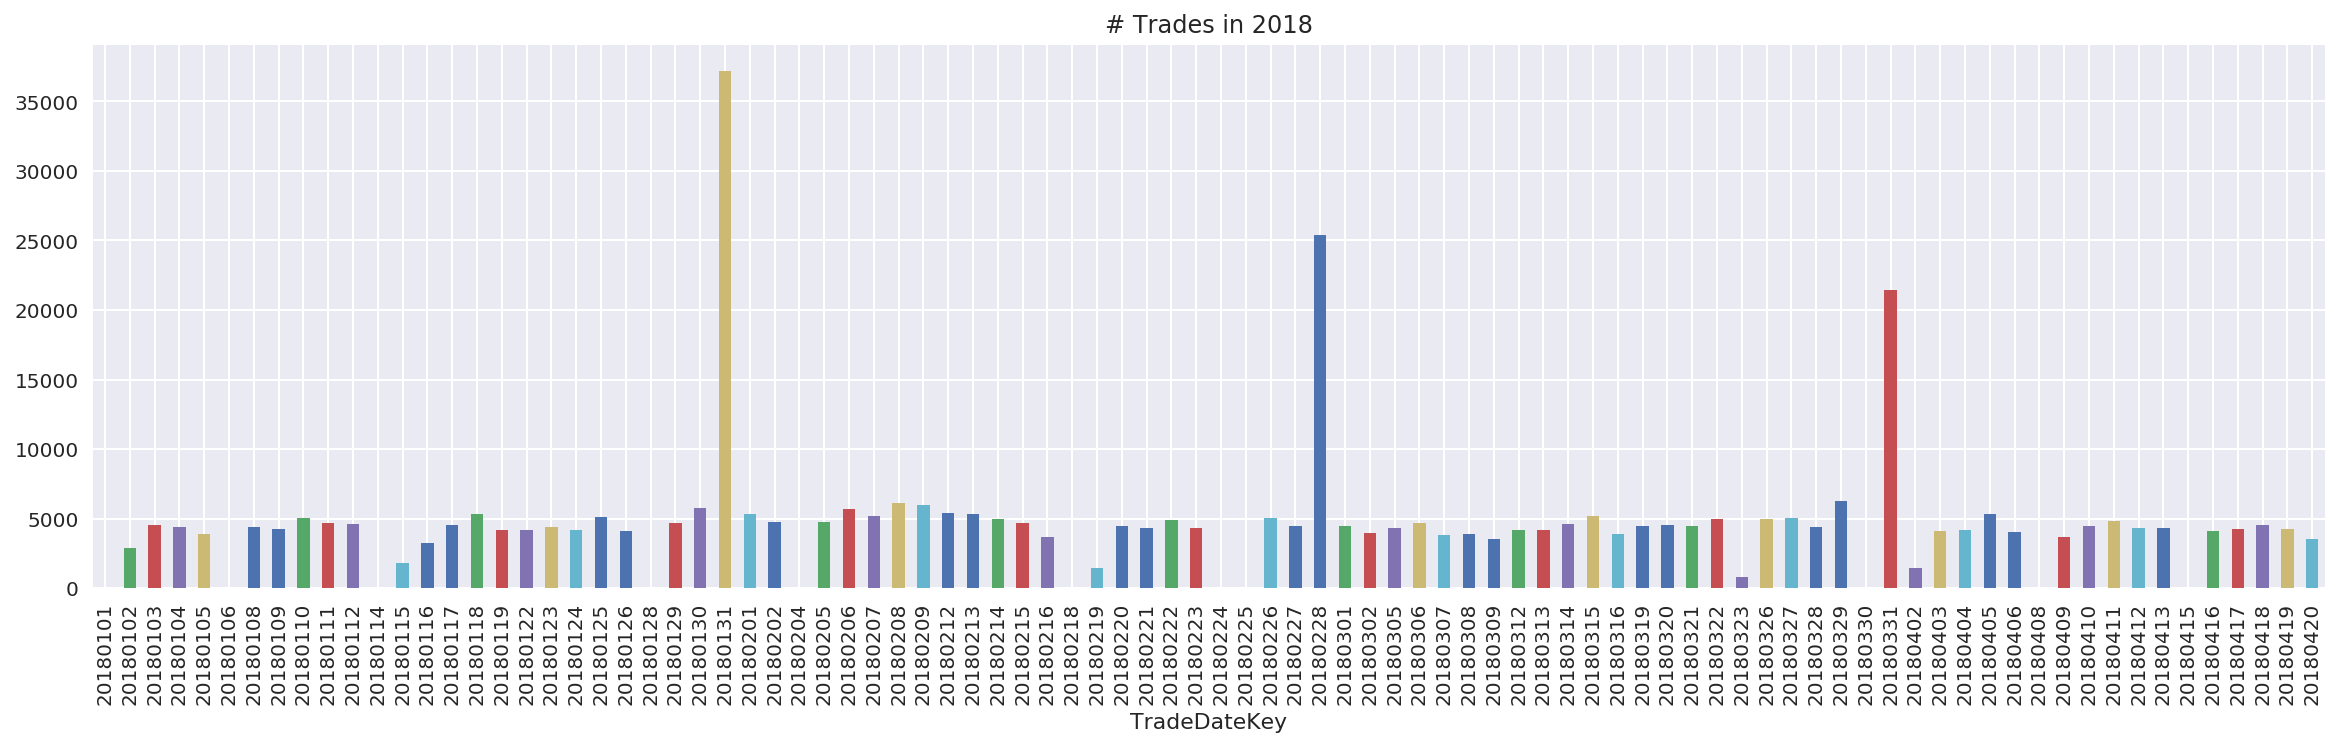

In [263]:
df[df.TradeDateKey > 20180000].groupby('TradeDateKey').size().sort_index().plot.bar(figsize=(20,5), title='# Trades in 2018')

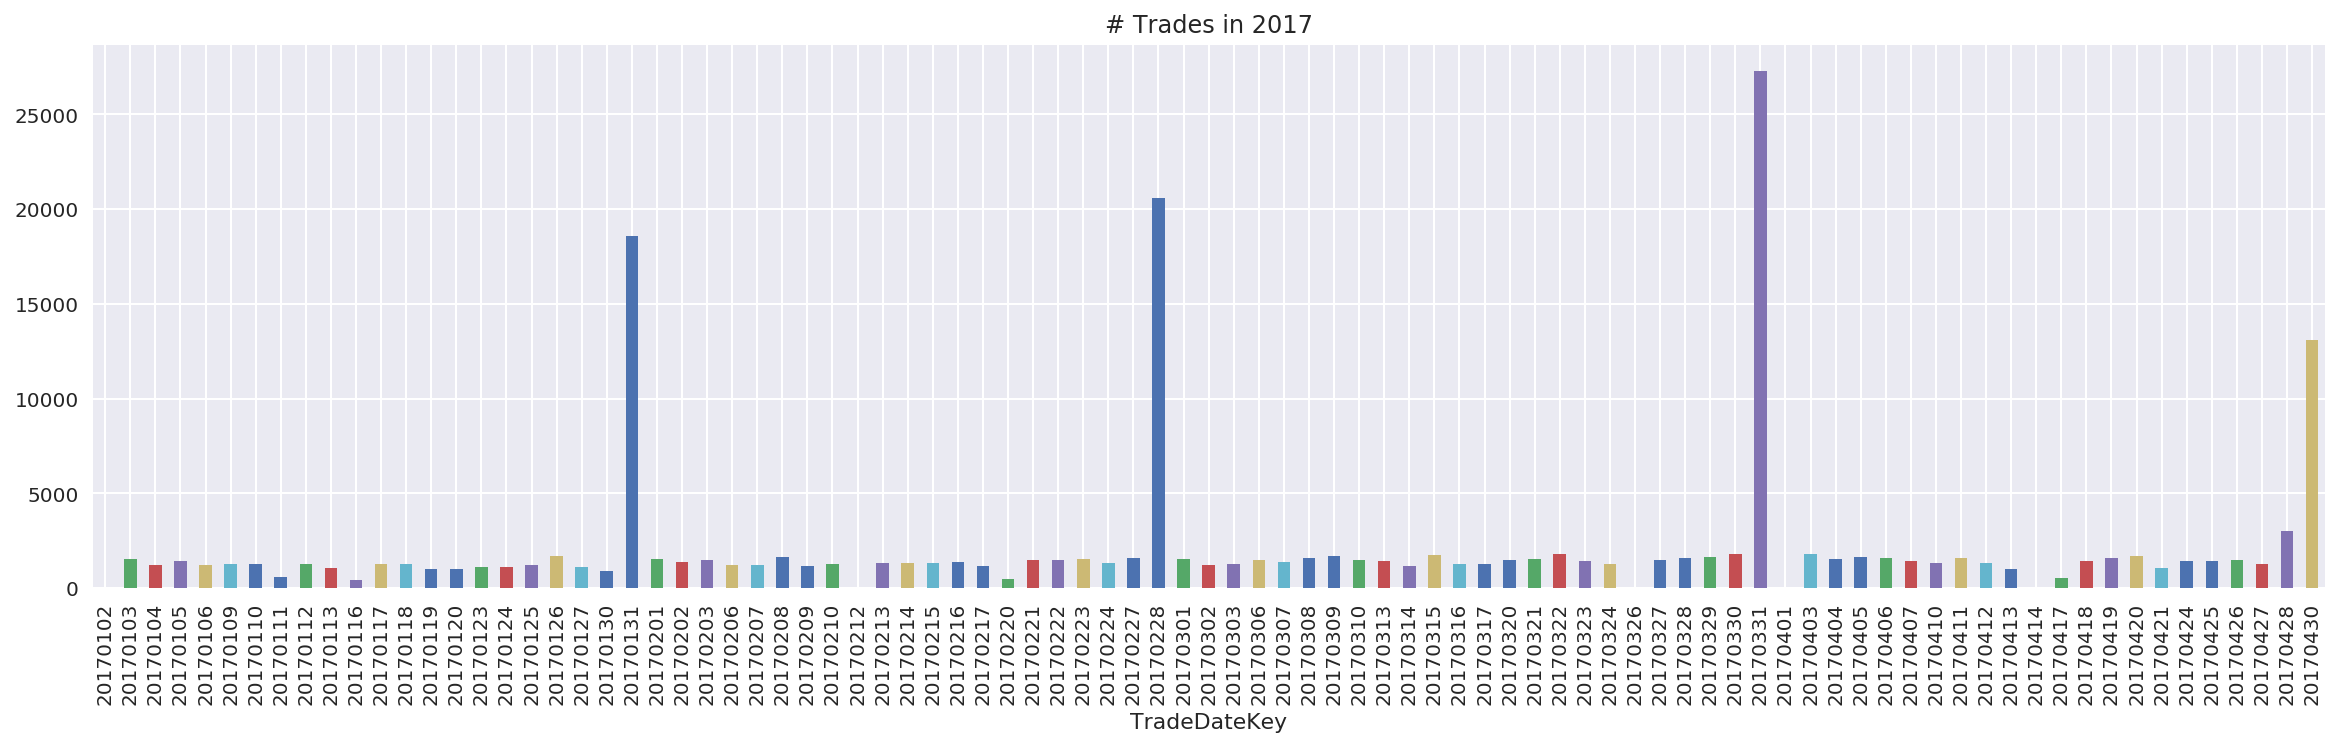

In [264]:
df[(df.TradeDateKey > 20170000) & (df.TradeDateKey < 20170500)].groupby('TradeDateKey').size().sort_index().plot.bar(figsize=(20,5), title='# Trades in 2017')

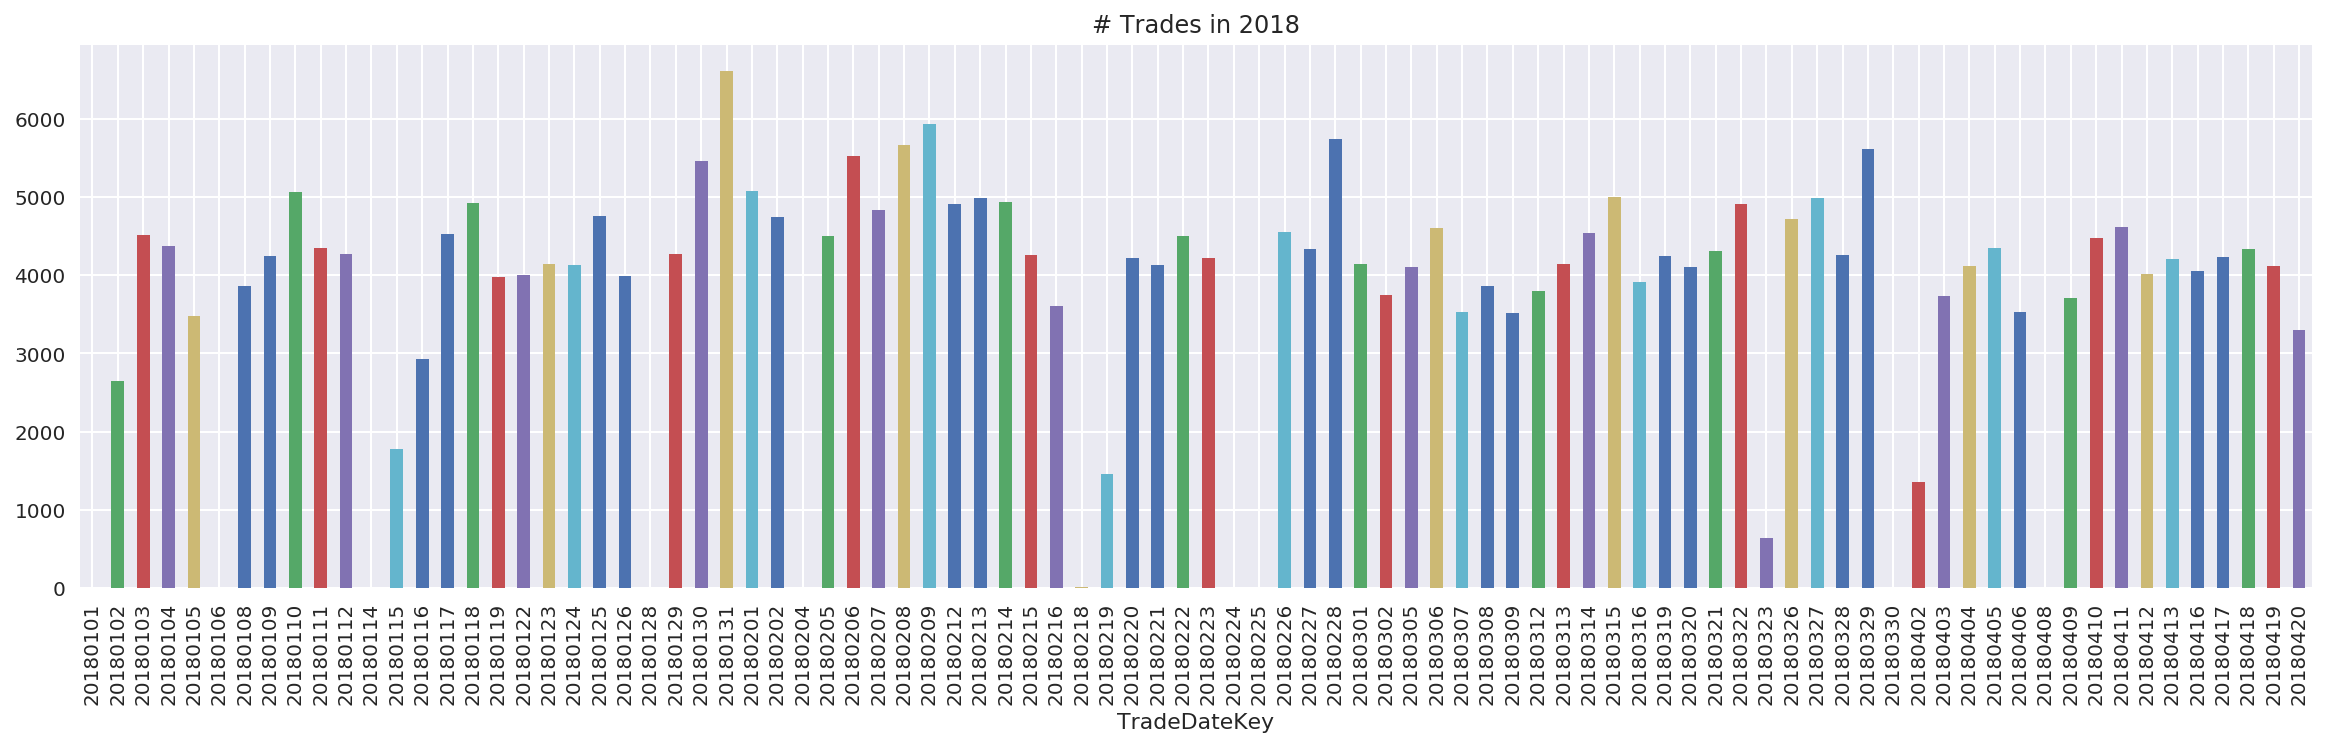

In [265]:
df[(df.TradeDateKey > 20180000) & (df.CustomerInterest == 1)].groupby('TradeDateKey') \
                .size().sort_index().plot.bar(figsize=(20,5), title='# Trades in 2018')

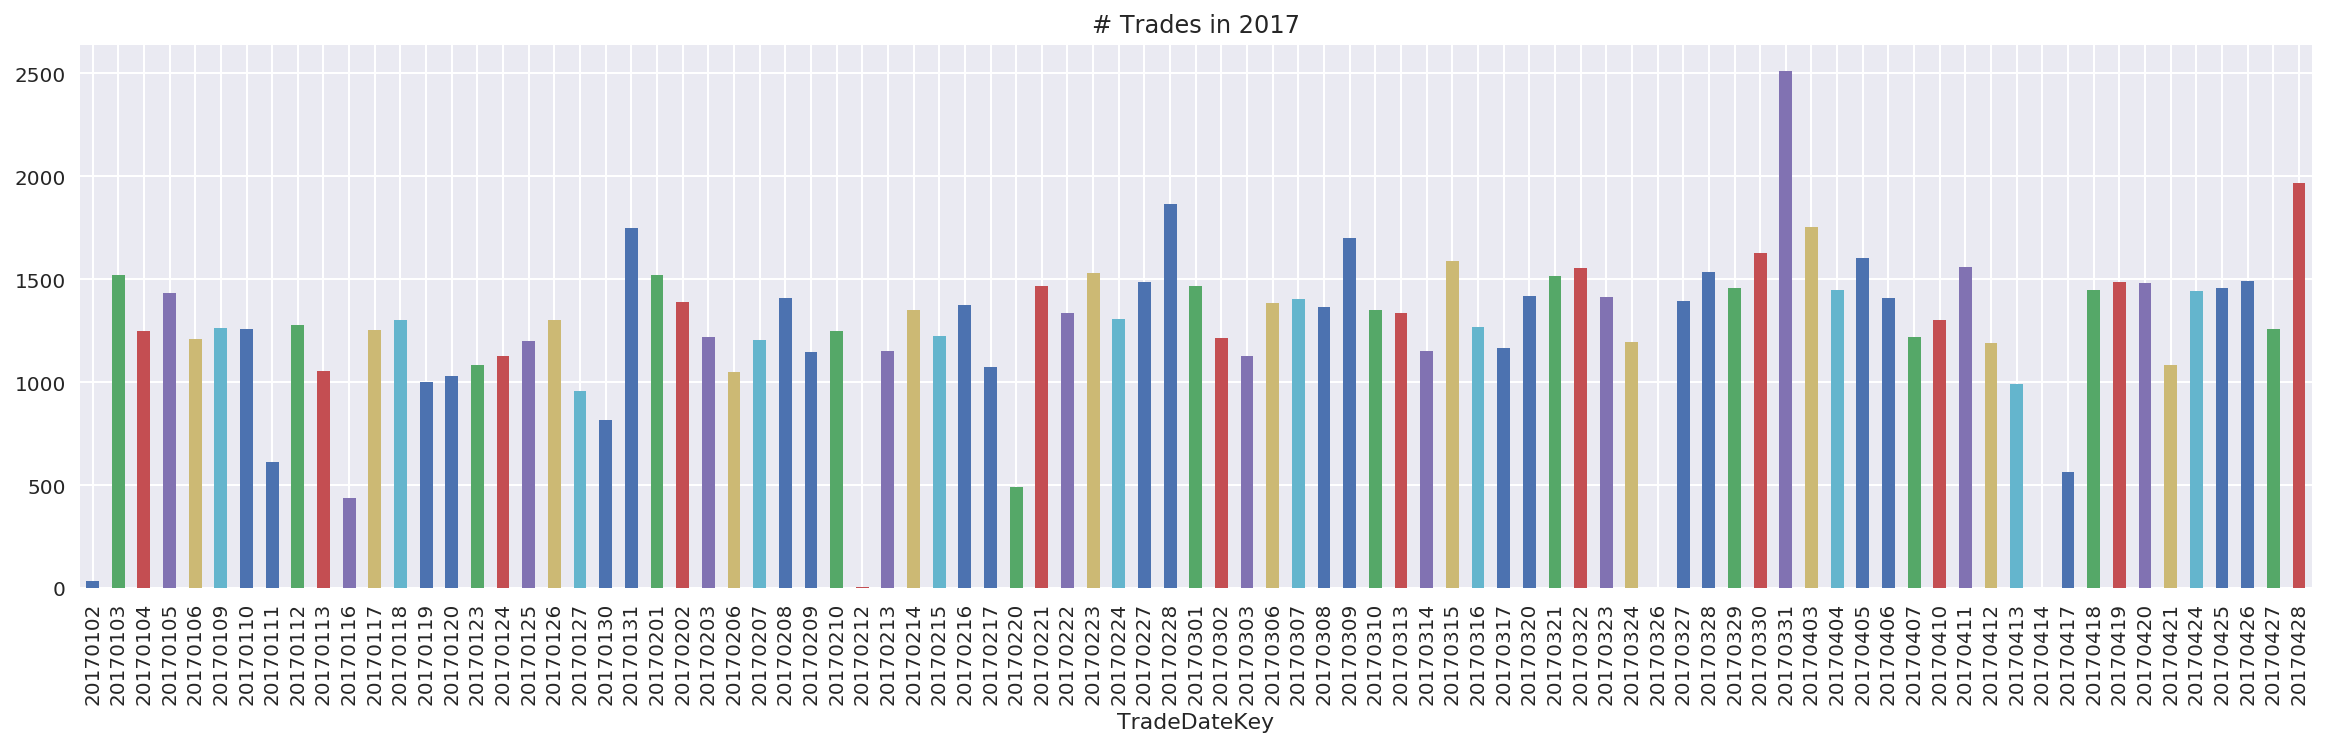

In [266]:
df[(df.TradeDateKey > 20170000) & (df.TradeDateKey < 20170500) & (df.CustomerInterest == 1)].groupby('TradeDateKey') \
                .size().sort_index().plot.bar(figsize=(20,5), title='# Trades in 2017')

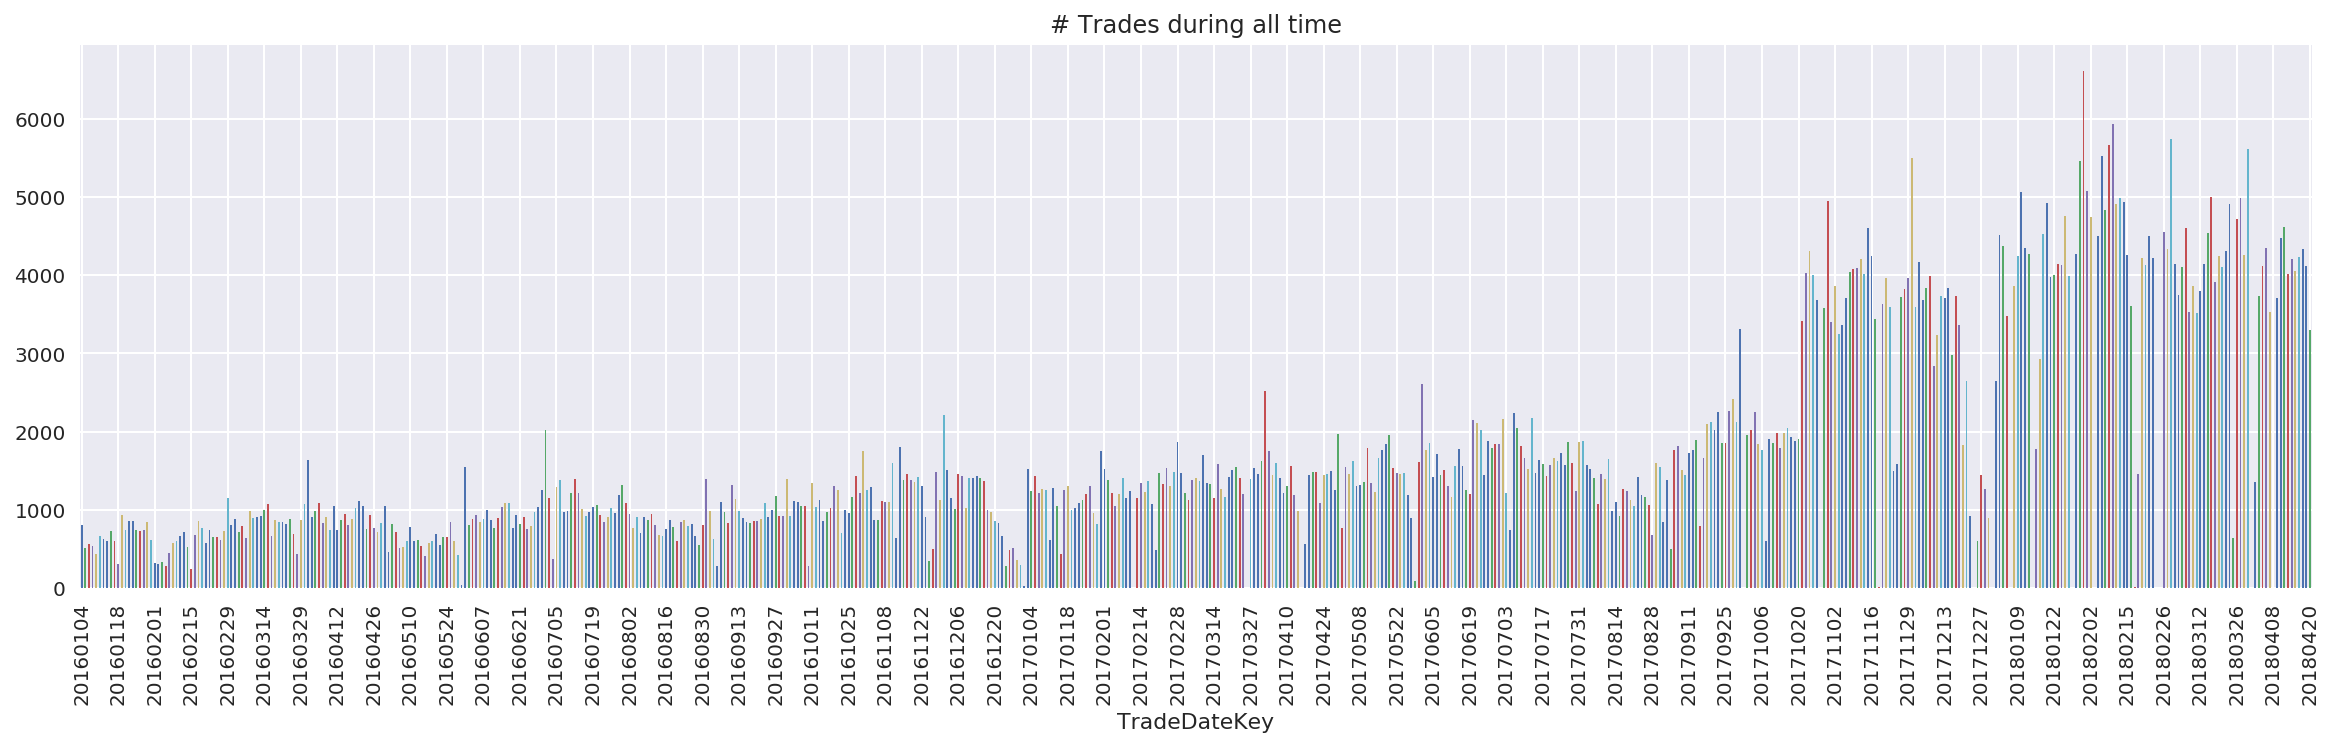

In [271]:
ax = df[df.CustomerInterest == 1].groupby('TradeDateKey') \
                .size().sort_index().plot.bar(figsize=(20,5), title='# Trades during all time')
n = 10
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
_ = ax.xaxis.set_ticklabels(ticklabels[::n])

In [278]:
from datetime import date, timedelta

d1 = date(2016, 1, 1)  # start date
d2 = date(2018, 5, 1)  # end date
delta = d2 - d1        # timedelta
days = [d1 + timedelta(i) for i in range(delta.days + 1)]

In [299]:
days_labels = {int(f'{day.year}{day.month:02}{day.day:02}'): 0 for day in days}
for idx, row in df[df.CustomerInterest == 1].groupby('TradeDateKey').size().sort_index().iteritems():
    days_labels[idx] = row
days_labels = pd.Series(days_labels)

In [308]:
len(days_labels)

852

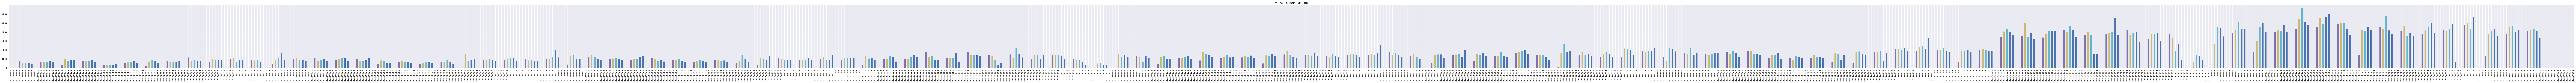

In [310]:
ax = days_labels.plot.bar(figsize=(200,5), title='# Trades during all time')
# n = 10
# ticks = ax.xaxis.get_ticklocs()
# ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
# ax.xaxis.set_ticks(ticks[::n])
# _ = ax.xaxis.set_ticklabels(ticklabels[::n])

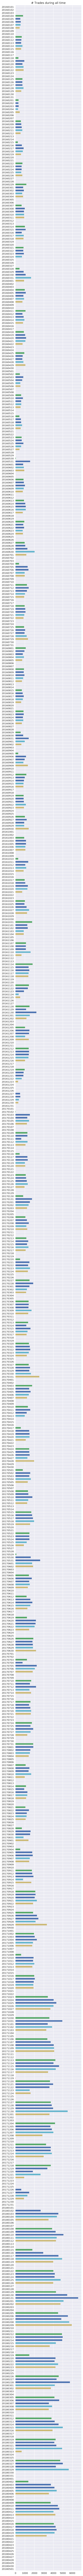

In [314]:
ax = days_labels.sort_index(ascending=False).plot.barh(figsize=(5,200), title='# Trades during all time')

In [267]:
df[(df.TradeDateKey > 20180000) & (df.CustomerInterest == 1)].groupby('TradeDateKey').size().describe()

count      88.000000
mean     3742.579545
std      1614.598642
min         1.000000
25%      3688.750000
50%      4214.500000
75%      4567.250000
max      6616.000000
dtype: float64

In [268]:
df[(df.TradeDateKey > 20170000) & (df.TradeDateKey < 20170500) & (df.CustomerInterest == 1)].groupby('TradeDateKey').size().describe()

count      87.000000
mean     1257.103448
std       402.322994
min         3.000000
25%      1151.500000
50%      1304.000000
75%      1463.500000
max      2514.000000
dtype: float64

In [316]:
len(customer), len(isin), len(challenge)

(3471, 27411, 484758)

## Previous day (Friday)

In [317]:
trade.sort_values('TradeDateKey', ascending=False).head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
5675819,20180422,3032,6499,Buy,817906.0,NaN,Holding,0.0
5678094,20180422,3032,15308,Buy,2658687.0,NaN,Holding,0.0
5678090,20180422,3032,15303,Buy,1615037.0,NaN,Holding,0.0
104490,20180420,1884,25895,Sell,810570.0,99.125,Unknown,1.0
5150459,20180420,2655,7463,Sell,236500.0,NaN,Holding,0.0


In [318]:
previous_friday = trade[trade.TradeDateKey==20180420]

In [321]:
previous_friday[previous_friday.CustomerInterest == 1].shape

(3588, 8)

In [322]:
# All customers of previous day are included in test
set(previous_friday[previous_friday.CustomerInterest == 1]['CustomerIdx']).difference(challenge.CustomerIdx)

set()

In [324]:
# 169/2520 of the bonds of previous day are not included in test
len(set(previous_friday[previous_friday.CustomerInterest == 1]['IsinIdx']).difference(challenge.IsinIdx))

169

In [325]:
previous_friday[previous_friday.CustomerInterest == 1]['IsinIdx'].nunique(), \
challenge.IsinIdx.nunique()

(2520, 18265)

In [330]:
filtered_friday = previous_friday[previous_friday.CustomerInterest == 1]

In [371]:
len(set(zip(filtered_friday.CustomerIdx, filtered_friday.IsinIdx))), len(set(zip(challenge.CustomerIdx, challenge.IsinIdx)))

(3166, 242379)

In [368]:
# 253/3166 of the customer,bond pairs of previous day are not included in test
len(set(zip(filtered_friday.CustomerIdx, filtered_friday.IsinIdx)).difference(zip(challenge.CustomerIdx, challenge.IsinIdx)))

253

In [331]:
filtered_friday.groupby('CustomerIdx').size().describe()

count    596.000000
mean       6.020134
std       12.731339
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max      178.000000
dtype: float64

In [333]:
filtered_friday.groupby(['CustomerIdx', 'IsinIdx']).size().describe()

count    3166.000000
mean        1.133291
std         0.514483
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
dtype: float64

In [337]:
groups_size = filtered_friday.groupby(['CustomerIdx', 'IsinIdx']).size()
groups_size[groups_size>1].shape

(297,)

In [340]:
# There may be an interest in both buying or selling the same bond in the same day 
filtered_friday[(filtered_friday.CustomerIdx == 317) & (filtered_friday.IsinIdx == 27066)]

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
1063586,20180420,317,27066,Sell,15000000.0,101.373,Unknown,1.0
1063587,20180420,317,27066,Sell,15000000.0,101.376,NotTraded,1.0
1063588,20180420,317,27066,Sell,5000000.0,101.125,NotTraded,1.0
2173751,20180420,317,27066,Sell,21000000.0,NaN,Done,1.0
2179209,20180420,317,27066,Sell,21000000.0,NaN,Done,1.0
2185624,20180420,317,27066,Sell,21000000.0,NaN,Done,1.0
2191054,20180420,317,27066,Sell,21000000.0,NaN,Done,1.0
2201688,20180420,317,27066,Sell,21000000.0,NaN,Done,1.0


In [336]:
# There may be an interest in both buying and selling the same bond in the same day 
filtered_friday[(filtered_friday.CustomerIdx == 939) & (filtered_friday.IsinIdx == 15297)]

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
124011,20180420,939,15297,Sell,19539201.0,98.4531,Done,1.0
124673,20180420,939,15297,Sell,2442400.0,98.4531,Done,1.0
280483,20180420,939,15297,Buy,21167467.0,98.4609,Done,1.0
487491,20180420,939,15297,Buy,1139787.0,98.4102,Done,1.0
488068,20180420,939,15297,Sell,18725067.0,98.5625,Done,1.0
707774,20180420,939,15297,Sell,1139787.0,98.4102,Done,1.0
848784,20180420,939,15297,Buy,18725067.0,98.5625,Done,1.0
848970,20180420,939,15297,Buy,2442400.0,98.4531,Done,1.0


In [329]:
# half of the customers have up to 12 bonds (max is 5044)
(challenge.groupby('CustomerIdx').size()/2).describe()

count    2495.000000
mean       97.145892
std       301.375388
min         1.000000
25%         3.000000
50%        12.000000
75%        58.000000
max      5044.000000
dtype: float64

In [341]:
challenge.head()

,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,a1e0d80784,20180423,1856,13323,Buy,NaN
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN
2,a8e94f6344,20180423,1780,9157,Buy,NaN
3,758bae1e35,20180423,2129,9131,Buy,NaN
4,02ab378ee8,20180423,1758,7151,Buy,NaN


In [342]:
previous_friday.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
16522,20180420,1758,11603,Sell,717354.0,98.2065,NotTraded,1.0
16829,20180420,2443,4495,Sell,810570.0,98.9241,Unknown,1.0
16999,20180420,1277,7219,Sell,567399.0,128.1250,Unknown,1.0
17243,20180420,2834,4086,Buy,1294638.0,98.3658,Done,1.0
17361,20180420,1551,4086,Buy,2589277.0,98.2544,Done,1.0


In [346]:
validation = trade[['TradeDateKey', 'CustomerIdx', 'IsinIdx', 'BuySell', 'CustomerInterest']].drop_duplicates().sort_values('TradeDateKey')

In [348]:
val_groups = validation.groupby(['TradeDateKey', 'CustomerIdx', 'IsinIdx', 'BuySell']).size()

In [349]:
val_groups.describe()

count    6.503262e+06
mean     1.001807e+00
std      4.247149e-02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.000000e+00
dtype: float64

In [352]:
# There may be an interest and non-interest in buying/selling the same bond in the same day 
trade[(trade.CustomerIdx == 68) & (trade.IsinIdx == 12951) & (trade.TradeDateKey == 20160229)]

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
1045543,20160229,68,12951,Sell,965162.0,117.75,Done,1.0
2252430,20160229,68,12951,Sell,314211.0,NaN,Holding,0.0


In [354]:
# There may be an interest and non-interest in buying/selling the same bond in the same day 
trade[(trade.CustomerIdx == 3122) & (trade.IsinIdx == 25189) & (trade.TradeDateKey == 20180419)]

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
1416113,20180419,3122,25189,Sell,3100000.0,104.375,NotTraded,1.0
5762228,20180419,3122,25189,Sell,1012838.0,NaN,Holding,0.0


In [355]:
print(val_groups[val_groups>1].shape)

(11752,)


In [362]:
validation.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
6762020,20160101,3470,13501,Buy,0.0
6245467,20160101,1929,12954,Buy,0.0
6245466,20160101,1929,12952,Sell,0.0
6245465,20160101,1929,12926,Sell,0.0
6245464,20160101,1929,12912,Sell,0.0


In [363]:
validation.to_csv(PROCESSED/'validation.csv', index=False)

In [367]:
validation.reset_index().to_feather(PROCESSED/'validation.feather')

In [364]:
df = pd.read_csv(PROCESSED/'validation.csv')

In [365]:
df.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,20160101,3470,13501,Buy,0.0
1,20160101,1929,12954,Buy,0.0
2,20160101,1929,12952,Sell,0.0
3,20160101,1929,12926,Sell,0.0
4,20160101,1929,12912,Sell,0.0
